
# Pure Substance Properties using Canteras and Coolprops built-in EOSs, as well as the Burke Mechanism

This is a comparison between several equations of state using Cantera and CoolProp. \
The fluids considered are H2, O2, N2, CH4 (Reactants), as well as H2O and CO2 (Products). \
The following EOS are used:

1. The ideal gas EOSs in Canteras gri30 and gri30_ion Mechanisms, and the Burke Mechanism
2. The Redlich-Kwong EOS from Canteras h2o2.yaml (does not have CO2, CH4!)
3. The Purefluid EOSs from Cantera (Diverse sources)
4. The Helmholtz energy EOS (HEOS) from CoolProp
5. The Suave-Redlich-Kwong & Peng-Robinson EOSs from Coolprop

Code Structure: https://cantera.org/stable/examples/python/thermo/equations_of_state.html \
Canteras Purefluid Objects: https://cantera.org/stable/python/importing.html#pure-fluid-phases \
High Level CoolProp Cubics usage: http://www.coolprop.org/coolprop/Cubics.html#cubic-backend \
Coolprop Low Level Interface: http://www.coolprop.org/coolprop/LowLevelAPI.html \
Burke Mechanism: https://burke.me.columbia.edu/content/mechanisms-and-downloads

In [5]:
import cantera as ct
import numpy as np
import CoolProp.CoolProp as CP
from CoolProp.CoolProp import PropsSI #High Level CoolProp interface
import matplotlib.pyplot as plt
import pandas as pd

First we set up the backend functions for property calculations, identically to the Non-Ideal EOS Cantera database example. \
As is noted there, since the standard-reference thermodynamic states for Cantera and Coolprop are different, it is necessary to convert these values to the same scale before comparison, in this case 1 bar, 300 K.

In [6]:
def get_thermo_Cantera_Mech(phase, T, p, X):
    states = ct.SolutionArray(phase, len(p))
    states.TPX = T, p, X

    u = states.u / 1000
    h = states.h / 1000
    s = states.s / 1000
    cp = states.cp / 1000
    cv = states.cv / 1000
    rho = states.density

    # Get the relative enthalpy, entropy and int. energy with reference to the first point
    u = u - u[0]
    s = s - s[0]
    h = h - h[0]

    return h, u, s, cp, cv, rho

def get_thermo_Cantera_PureFluid(T, p_array, Fluid): #PureFluids expect scalar values
    u, h, s, cp, cv, rho = [], [], [], [], [], [] #We need to set up lists
    for p in p_array: #And then loop through them
        Fluid.TP = T, p
        u.append(Fluid.u / 1000)
        h.append(Fluid.h / 1000)
        s.append(Fluid.s / 1000)
        cp.append(Fluid.cp / 1000)
        cv.append(Fluid.cv / 1000)
        rho.append(Fluid.density)
    
    #Convert the lists to arrays
    u = np.array(u)
    h = np.array(h)
    s = np.array(s)
    cp = np.array(cp)
    cv = np.array(cv)
    rho = np.array(rho)
    
    # Get the relative enthalpy, entropy and int. energy with reference to the first point (can only be done with arrays)
    u = u - u[0]
    s = s - s[0]
    h = h - h[0]

    return h, u, s, cp, cv, rho

def get_thermo_CoolProp(T, p, EOSX):
    u = np.zeros_like(p)
    h = np.zeros_like(p)
    s = np.zeros_like(p)
    cp = np.zeros_like(p)
    cv = np.zeros_like(p)
    rho = np.zeros_like(p)

    for i in range(p.shape[0]):
        u[i] = PropsSI("U", "P", p[i], "T", T, EOSX)
        h[i] = PropsSI("H", "P", p[i], "T", T, EOSX)
        s[i] = PropsSI("S", "P", p[i], "T", T, EOSX)
        cp[i] = PropsSI("C", "P", p[i], "T", T, EOSX)
        cv[i] = PropsSI("O", "P", p[i], "T", T, EOSX)
        rho[i] = PropsSI("D", "P", p[i], "T", T, EOSX)

    # Get the relative enthalpy, entropy and int. energy with reference to the first
    # point
    u = (u - u[0]) / 1000
    s = (s - s[0]) / 1000
    h = (h - h[0]) / 1000
    cp = cp / 1000
    cv = cv / 1000
    rho = rho
    
    return h, u, s, cp, cv, rho

This is the main subroutine that compares the thermodynamic values obtained using different equation of state

Now we read in all the phases used. \
Note that we only need to specify a thermo for h2o2.yaml, as all the others used contain only one phase (ideal gas) \
For Pure Fluids, we need to use the correct strings ("CarbonDioxide" for CO2, "Hydrogen" for H2 etc.)

In [7]:
# Input parameters
T = 300  # Temperature is constant [K]
p = 101325 * np.linspace(1, 100, 100)  # Pressure is varied from 1 to 100 atm [Pa]

In [8]:
# Read the ideal-gas phase Objects
ideal_gas1 = ct.Solution('gri30.yaml')
ideal_gas2 = ct.Solution('gri30_ion.yaml')
ideal_gas3 = ct.Solution('Law Replication/Burke Mech/Burke_chem_cti.yaml')
ideal_gas4 = ct.Solution('h2o2.yaml',thermo='ideal-gas') #needs to be specified

# Read each ideal-gas Phase for Carbon Dioxide, not present in h2o2!
h_ideal_CO2_GRI, u_ideal_CO2_GRI, s_ideal_CO2_GRI, cp_ideal_CO2_GRI, cv_ideal_CO2_GRI, rho_ideal_CO2_GRI = get_thermo_Cantera_Mech(
    ideal_gas1, T, p, "CO2:1.0")
h_ideal_CO2_GRION, u_ideal_CO2_GRION, s_ideal_CO2_GRION, cp_ideal_CO2_GRION, cv_ideal_CO2_GRION, rho_ideal_CO2_GRION = get_thermo_Cantera_Mech(
    ideal_gas2, T, p, "CO2:1.0")
h_ideal_CO2_Burke, u_ideal_CO2_Burke, s_ideal_CO2_Burke, cp_ideal_CO2_Burke, cv_ideal_CO2_Burke, rho_ideal_CO2_Burke = get_thermo_Cantera_Mech(
    ideal_gas3, T, p, "CO2:1.0")

# Read each ideal-gas Phase for Hydrogen
h_ideal_H2_GRI, u_ideal_H2_GRI, s_ideal_H2_GRI, cp_ideal_H2_GRI, cv_ideal_H2_GRI, rho_ideal_H2_GRI = get_thermo_Cantera_Mech(
    ideal_gas1, T, p, "H2:1.0")
h_ideal_H2_GRION, u_ideal_H2_GRION, s_ideal_H2_GRION, cp_ideal_H2_GRION, cv_ideal_H2_GRION, rho_ideal_H2_GRION = get_thermo_Cantera_Mech(
    ideal_gas2, T, p, "H2:1.0")
h_ideal_H2_Burke, u_ideal_H2_Burke, s_ideal_H2_Burke, cp_ideal_H2_Burke, cv_ideal_H2_Burke, rho_ideal_H2_Burke = get_thermo_Cantera_Mech(
    ideal_gas3, T, p, "H2:1.0")
h_ideal_H2_h2o2, u_ideal_H2_h2o2, s_ideal_H2_h2o2, cp_ideal_H2_h2o2, cv_ideal_H2_h2o2, rho_ideal_H2_h2o2 = get_thermo_Cantera_Mech(
    ideal_gas4, T, p, "H2:1.0")

# Read each ideal-gas Phase for Methane, not present in Burke & h2o2!
h_ideal_CH4_GRI, u_ideal_CH4_GRI, s_ideal_CH4_GRI, cp_ideal_CH4_GRI, cv_ideal_CH4_GRI, rho_ideal_CH4_GRI = get_thermo_Cantera_Mech(
    ideal_gas1, T, p, "CH4:1.0")
h_ideal_CH4_GRION, u_ideal_CH4_GRION, s_ideal_CH4_GRION, cp_ideal_CH4_GRION, cv_ideal_CH4_GRION, rho_ideal_CH4_GRION = get_thermo_Cantera_Mech(
    ideal_gas2, T, p, "CH4:1.0")

# Read each ideal-gas Phase for Nitrogen
h_ideal_N2_GRI, u_ideal_N2_GRI, s_ideal_N2_GRI, cp_ideal_N2_GRI, cv_ideal_N2_GRI, rho_ideal_N2_GRI = get_thermo_Cantera_Mech(
    ideal_gas1, T, p, "N2:1.0")
h_ideal_N2_GRION, u_ideal_N2_GRION, s_ideal_N2_GRION, cp_ideal_N2_GRION, cv_ideal_N2_GRION, rho_ideal_N2_GRION = get_thermo_Cantera_Mech(
    ideal_gas2, T, p, "N2:1.0")
h_ideal_N2_Burke, u_ideal_N2_Burke, s_ideal_N2_Burke, cp_ideal_N2_Burke, cv_ideal_N2_Burke, rho_ideal_N2_Burke = get_thermo_Cantera_Mech(
    ideal_gas3, T, p, "N2:1.0")
h_ideal_N2_N2o2, u_ideal_N2_h2o2, s_ideal_N2_h2o2, cp_ideal_N2_h2o2, cv_ideal_N2_h2o2, rho_ideal_N2_h2o2 = get_thermo_Cantera_Mech(
    ideal_gas4, T, p, "N2:1.0")

# Read each ideal-gas Phase for Oxygen
h_ideal_O2_GRI, u_ideal_O2_GRI, s_ideal_O2_GRI, cp_ideal_O2_GRI, cv_ideal_O2_GRI, rho_ideal_O2_GRI = get_thermo_Cantera_Mech(
    ideal_gas1, T, p, "O2:1.0")
h_ideal_O2_GRION, u_ideal_O2_GRION, s_ideal_O2_GRION, cp_ideal_O2_GRION, cv_ideal_O2_GRION, rho_ideal_O2_GRION = get_thermo_Cantera_Mech(
    ideal_gas2, T, p, "O2:1.0")
h_ideal_O2_Burke, u_ideal_O2_Burke, s_ideal_O2_Burke, cp_ideal_O2_Burke, cv_ideal_O2_Burke, rho_ideal_O2_Burke = get_thermo_Cantera_Mech(
    ideal_gas3, T, p, "O2:1.0")
h_ideal_O2_O2o2, u_ideal_O2_h2o2, s_ideal_O2_h2o2, cp_ideal_O2_h2o2, cv_ideal_O2_h2o2, rho_ideal_O2_h2o2 = get_thermo_Cantera_Mech(
    ideal_gas4, T, p, "O2:1.0")

# Read each ideal-gas Phase for Water
h_ideal_H2O_GRI, u_ideal_H2O_GRI, s_ideal_H2O_GRI, cp_ideal_H2O_GRI, cv_ideal_H2O_GRI, rho_ideal_H2O_GRI = get_thermo_Cantera_Mech(
    ideal_gas1, T, p, "H2O:1.0")
h_ideal_H2O_GRION, u_ideal_H2O_GRION, s_ideal_H2O_GRION, cp_ideal_H2O_GRION, cv_ideal_H2O_GRION, rho_ideal_H2O_GRION = get_thermo_Cantera_Mech(
    ideal_gas2, T, p, "H2O:1.0")
h_ideal_H2O_Burke, u_ideal_H2O_Burke, s_ideal_H2O_Burke, cp_ideal_H2O_Burke, cv_ideal_H2O_Burke, rho_ideal_H2O_Burke = get_thermo_Cantera_Mech(
    ideal_gas3, T, p, "H2O:1.0")
h_ideal_H2O_H2OH2O, u_ideal_H2O_h2o2, s_ideal_H2O_h2o2, cp_ideal_H2O_h2o2, cv_ideal_H2O_h2o2, rho_ideal_H2O_h2o2 = get_thermo_Cantera_Mech(
    ideal_gas4, T, p, "H2O:1.0")

In [9]:
# Read Canteras Redlich-Kwong phase, No data for CO2/CH4 is available in h2o2.yaml!
redlich_kwong = ct.Solution('h2o2.yaml',thermo='R-K')
h_RK_H2, u_RK_H2, s_RK_H2, cp_RK_H2, cv_RK_H2, rho_RK_H2 = get_thermo_Cantera_Mech(redlich_kwong_phase, T, p, "H2:1.0")
h_RK_N2, u_RK_N2, s_RK_N2, cp_RK_N2, cv_RK_N2, rho_RK_N2 = get_thermo_Cantera_Mech(redlich_kwong_phase, T, p, "N2:1.0")
h_RK_O2, u_RK_O2, s_RK_O2, cp_RK_O2, cv_RK_O2, rho_RK_O2 = get_thermo_Cantera_Mech(redlich_kwong_phase, T, p, "O2:1.0")
h_RK_H2O, u_RK_H2O, s_RK_H2O, cp_RK_H2O, cv_RK_H2O, rho_RK_H2O = get_thermo_Cantera_Mech(redlich_kwong_phase, T, p, "H2O:1.0")

NameError: name 'redlich_kwong_phase' is not defined

In [10]:
# Read each Cantera PureFluid, Valid Purefluids are CarbonDioxide, Hydrogen, Methane, Nitrogen, Oxygen, Water
CO2_Pure = ct.CarbonDioxide()
H2_Pure = ct.Hydrogen()
CH4_Pure = ct.Methane()
N2_Pure = ct.Nitrogen()
O2_Pure = ct.Oxygen()
H2O_Pure = ct.Water()

# Compute all PureFluid states
h_Pure_CO2, u_Pure_CO2, s_Pure_CO2, cp_Pure_CO2, cv_Pure_CO2, rho_Pure_CO2 = get_thermo_Cantera_PureFluid(T, p, CO2_Pure)
h_Pure_H2, u_Pure_H2, s_Pure_H2, cp_Pure_H2, cv_Pure_H2, rho_Pure_H2 = get_thermo_Cantera_PureFluid(T, p, H2_Pure)
h_Pure_CH4, u_Pure_CH4, s_Pure_CH4, cp_Pure_CH4, cv_Pure_CH4, rho_Pure_CH4 = get_thermo_Cantera_PureFluid(T, p, CH4_Pure)
h_Pure_N2, u_Pure_N2, s_Pure_N2, cp_Pure_N2, cv_Pure_N2, rho_Pure_N2 = get_thermo_Cantera_PureFluid(T, p, N2_Pure)
h_Pure_O2, u_Pure_O2, s_Pure_O2, cp_Pure_O2, cv_Pure_O2, rho_Pure_O2 = get_thermo_Cantera_PureFluid(T, p, O2_Pure)
h_Pure_H2O, u_Pure_H2O, s_Pure_H2O, cp_Pure_H2O, cv_Pure_H2O, rho_Pure_H2O = get_thermo_Cantera_PureFluid(T, p, H2O_Pure)

In [11]:
# Read the Thermo data using CoolProp, for each species & each EOS

#Helmholtz
h_CoolProp_HEOS_CO2, u_CoolProp_HEOS_CO2, s_CoolProp_HEOS_CO2, cp_CoolProp_HEOS_CO2, cv_CoolProp_HEOS_CO2, rho_CoolProp_HEOS_CO2 \
= get_thermo_CoolProp(T, p, "HEOS::CO2")
h_CoolProp_HEOS_H2, u_CoolProp_HEOS_H2, s_CoolProp_HEOS_H2, cp_CoolProp_HEOS_H2, cv_CoolProp_HEOS_H2, rho_CoolProp_HEOS_H2 \
= get_thermo_CoolProp(T, p, "HEOS::H2")
h_CoolProp_HEOS_CH4, u_CoolProp_HEOS_CH4, s_CoolProp_HEOS_CH4, cp_CoolProp_HEOS_CH4, cv_CoolProp_HEOS_CH4, rho_CoolProp_HEOS_CH4 \
= get_thermo_CoolProp(T, p, "HEOS::CH4")
h_CoolProp_HEOS_N2, u_CoolProp_HEOS_N2, s_CoolProp_HEOS_N2, cp_CoolProp_HEOS_N2, cv_CoolProp_HEOS_N2, rho_CoolProp_HEOS_N2 \
= get_thermo_CoolProp(T, p, "HEOS::N2")
h_CoolProp_HEOS_O2, u_CoolProp_HEOS_O2, s_CoolProp_HEOS_O2, cp_CoolProp_HEOS_O2, cv_CoolProp_HEOS_O2, rho_CoolProp_HEOS_O2 \
= get_thermo_CoolProp(T, p, "HEOS::O2")
h_CoolProp_HEOS_H2O, u_CoolProp_HEOS_H2O, s_CoolProp_HEOS_H2O, cp_CoolProp_HEOS_H2O, cv_CoolProp_HEOS_H2O, rho_CoolProp_HEOS_H2O \
= get_thermo_CoolProp(T, p, "HEOS::H2O")

#SRK
h_CoolProp_SRK_CO2, u_CoolProp_SRK_CO2, s_CoolProp_SRK_CO2, cp_CoolProp_SRK_CO2, cv_CoolProp_SRK_CO2, rho_CoolProp_SRK_CO2 \
= get_thermo_CoolProp(T, p, "SRK::CO2")
h_CoolProp_SRK_H2, u_CoolProp_SRK_H2, s_CoolProp_SRK_H2, cp_CoolProp_SRK_H2, cv_CoolProp_SRK_H2, rho_CoolProp_SRK_H2 \
= get_thermo_CoolProp(T, p, "SRK::H2")
h_CoolProp_SRK_CH4, u_CoolProp_SRK_CH4, s_CoolProp_SRK_CH4, cp_CoolProp_SRK_CH4, cv_CoolProp_SRK_CH4, rho_CoolProp_SRK_CH4 \
= get_thermo_CoolProp(T, p, "SRK::CH4")
h_CoolProp_SRK_N2, u_CoolProp_SRK_N2, s_CoolProp_SRK_N2, cp_CoolProp_SRK_N2, cv_CoolProp_SRK_N2, rho_CoolProp_SRK_N2 \
= get_thermo_CoolProp(T, p, "SRK::N2")
h_CoolProp_SRK_O2, u_CoolProp_SRK_O2, s_CoolProp_SRK_O2, cp_CoolProp_SRK_O2, cv_CoolProp_SRK_O2, rho_CoolProp_SRK_O2 \
= get_thermo_CoolProp(T, p, "SRK::O2")
h_CoolProp_SRK_H2O, u_CoolProp_SRK_H2O, s_CoolProp_SRK_H2O, cp_CoolProp_SRK_H2O, cv_CoolProp_SRK_H2O, rho_CoolProp_SRK_H2O \
= get_thermo_CoolProp(T, p, "SRK::H2O")

In [12]:
#PR Threw errors near phase transition
#So we will rewrite the general method to include a density guess using an AbstractState from the CP Low level interface
def get_thermo_CoolProp_PR(T, p, X):
    AS = CP.AbstractState("PR", X)
    u = np.zeros_like(p)
    h = np.zeros_like(p)
    s = np.zeros_like(p)
    cp = np.zeros_like(p)
    cv = np.zeros_like(p)
    rho = np.zeros_like(p)
    for i in range(p.shape[0]):
        rho_guess = PropsSI("D", "P", p[i], "T", T, X)
        AS.update(CP.DmassT_INPUTS, rho_guess, T)
        AS.update(CP.PT_INPUTS, p[i], T)
        u[i] = AS.umass()
        h[i] = AS.hmass()
        s[i] = AS.smass()
        cp[i] = AS.cpmass()
        cv[i] = AS.cvmass()
        rho[i] = AS.rhomass()
    # Get the relative enthalpy, entropy and int. energy with reference to the first
    # point
    u = (u - u[0]) / 1000
    s = (s - s[0]) / 1000
    h = (h - h[0]) / 1000
    cp = cp / 1000
    cv = cv / 1000
    rho = rho
    
    return h, u, s, cp, cv, rho

In [23]:
def get_thermo_CoolProp_PR(T, p, X):
    AS = CP.AbstractState("PR", X)
    u = np.zeros_like(p)
    h = np.zeros_like(p)
    s = np.zeros_like(p)
    cp = np.zeros_like(p)
    cv = np.zeros_like(p)
    rho = np.zeros_like(p)
    for i in range(p.shape[0]):
        rho_guess = PropsSI("D", "P", p[i], "T", T, X)
        AS.update(CP.DmassT_INPUTS, rho_guess, T)
#        AS.update(CP.PT_INPUTS, p[i], T)
        u[i] = AS.umass()
        h[i] = AS.hmass()
        s[i] = AS.smass()
        cp[i] = AS.cpmass()
        cv[i] = AS.cvmass()
        rho[i] = AS.rhomass()
    # Get the relative enthalpy, entropy and int. energy with reference to the first
    # point
    u = (u - u[0]) / 1000
    s = (s - s[0]) / 1000
    h = (h - h[0]) / 1000
    cp = cp / 1000
    cv = cv / 1000
    rho = rho
    
    return h, u, s, cp, cv, rho

In [21]:
#Now we will calculate the Thermodynamic states using the above method
h_CoolProp_PR_CO2, u_CoolProp_PR_CO2, s_CoolProp_PR_CO2, cp_CoolProp_PR_CO2, cv_CoolProp_PR_CO2, rho_CoolProp_PR_CO2 \
= get_thermo_CoolProp_PR(T, p, "CO2")
h_CoolProp_PR_CH4, u_CoolProp_PR_CH4, s_CoolProp_PR_CH4, cp_CoolProp_PR_CH4, cv_CoolProp_PR_CH4, rho_CoolProp_PR_CH4 \
= get_thermo_CoolProp_PR(T, p, "CH4")
h_CoolProp_PR_N2, u_CoolProp_PR_N2, s_CoolProp_PR_N2, cp_CoolProp_PR_N2, cv_CoolProp_PR_N2, rho_CoolProp_PR_N2 \
= get_thermo_CoolProp_PR(T, p, "N2")
h_CoolProp_PR_O2, u_CoolProp_PR_O2, s_CoolProp_PR_O2, cp_CoolProp_PR_O2, cv_CoolProp_PR_O2, rho_CoolProp_PR_O2 \
= get_thermo_CoolProp_PR(T, p, "O2")
h_CoolProp_PR_H2O, u_CoolProp_PR_H2O, s_CoolProp_PR_H2O, cp_CoolProp_PR_H2O, cv_CoolProp_PR_H2O, rho_CoolProp_PR_H2O \
= get_thermo_CoolProp_PR(T, p, "H2O")

In [24]:
h_CoolProp_PR_H2, u_CoolProp_PR_H2, s_CoolProp_PR_H2, cp_CoolProp_PR_H2, cv_CoolProp_PR_H2, rho_CoolProp_PR_H2 \
= get_thermo_CoolProp_PR(T, p, "H2")

In [25]:
print (h_CoolProp_PR_H2)

[ 0.         -0.17893325 -0.35454647 -0.52685747 -0.69588392 -0.86164336
 -1.0241532  -1.1834307  -1.339493   -1.49235711 -1.64203993 -1.78855819
 -1.93192853 -2.07216746 -2.20929136 -2.3433165  -2.47425903 -2.60213496
 -2.7269602  -2.84875057 -2.96752172 -3.08328924 -3.19606858 -3.30587508
 -3.41272398 -3.51663042 -3.6176094  -3.71567586 -3.8108446  -3.90313034
 -3.99254767 -4.0791111  -4.16283505 -4.2437338  -4.32182158 -4.3971125
 -4.46962055 -4.53935968 -4.60634369 -4.67058633 -4.73210122 -4.79090192
 -4.84700188 -4.90041447 -4.95115297 -4.99923057 -5.04466036 -5.08745536
 -5.12762851 -5.16519264 -5.20016052 -5.23254483 -5.26235816 -5.28961302
 -5.31432184 -5.33649698 -5.3561507  -5.37329521 -5.38794261 -5.40010494
 -5.40979415 -5.41702215 -5.42180072 -5.4241416  -5.42405646 -5.42155688
 -5.41665436 -5.40936035 -5.39968621 -5.38764325 -5.37324268 -5.35649566
 -5.33741328 -5.31600655 -5.29228642 -5.26626377 -5.23794942 -5.20735411
 -5.17448851 -5.13936325 -5.10198888 -5.06237587 -5.

Despite the Provided Density guess, the PR backend still fails for Hydrogen at pressures greater than 12 atmospheres, and continues to fail until 100 atm.
So, specifically for Hydrogen, we will try to set a Phase as well as Density guess

In [14]:
#Import needed Phase strings
from CoolProp import (
    iphase_liquid,
    iphase_gas,
    iphase_twophase,
    iphase_supercritical,
    iphase_supercritical_liquid,
    iphase_supercritical_gas,
    iphase_unknown
)
#Set up a string map
PHASE_MAP = {
    "liquid": iphase_liquid,
    "gas": iphase_gas,
    "two_phase": iphase_twophase,
    "supercritical": iphase_supercritical,
    "supercritical_liquid": iphase_supercritical_liquid,
    "supercritical_gas": iphase_supercritical_gas
}

AS = CP.AbstractState("PR", "H2")
u_H2 = np.zeros_like(p)
h_H2 = np.zeros_like(p)
s_H2 = np.zeros_like(p)
cp_H2 = np.zeros_like(p)
cv_H2 = np.zeros_like(p)
rho_H2 = np.zeros_like(p)
for i in range(p.shape[0]):
    phase_str = PropsSI("Phase", "T", T, "P", p[i], "H2")
    phase_enum = PHASE_MAP.get(phase_str, None)
    if phase_enum is not None:
        AS.specify_phase(phase_enum)        
    rho_guess = PropsSI("D", "P", p[i], "T", T, "H2")
    AS.update(CP.DmassT_INPUTS, rho_guess, T)
    try:
        AS.update(CP.PT_INPUTS, p[i], T)
    except ValueError as e: #Loops through all values despite the Errors
        print(f"Error updating state for P={p[i]}, T={T}: {e}") #Logs error
        continue 
    
    u_H2[i] = AS.umass()
    h_H2[i] = AS.hmass()
    s_H2[i] = AS.smass()
    cp_H2[i] = AS.cpmass()
    cv_H2[i] = AS.cvmass()
    rho_H2[i] = AS.rhomass()
    AS.unspecify_phase()

# First point reference
u_H2 = (u_H2 - u_H2[0]) / 1000
s_H2 = (s_H2 - s_H2[0]) / 1000
h_H2 = (h_H2 - h_H2[0]) / 1000
cp_H2 = cp_H2 / 1000
cv_H2 = cv_H2 / 1000
rho_H2 = rho_H2


h_CoolProp_PR_H2, u_CoolProp_PR_H2, s_CoolProp_PR_H2, cp_CoolProp_PR_H2, cv_CoolProp_PR_H2, rho_CoolProp_PR_H2 \
= get_thermo_CoolProp_PR(T, p, "H2")


Error updating state for P=1317225.0, T=300: Cubic has three roots, but phase not imposed and guess density not provided
Error updating state for P=1418550.0, T=300: Cubic has three roots, but phase not imposed and guess density not provided
Error updating state for P=1519875.0, T=300: Cubic has three roots, but phase not imposed and guess density not provided
Error updating state for P=1621200.0, T=300: Cubic has three roots, but phase not imposed and guess density not provided
Error updating state for P=1722525.0, T=300: Cubic has three roots, but phase not imposed and guess density not provided
Error updating state for P=1823850.0, T=300: Cubic has three roots, but phase not imposed and guess density not provided
Error updating state for P=1925175.0, T=300: Cubic has three roots, but phase not imposed and guess density not provided
Error updating state for P=2026500.0, T=300: Cubic has three roots, but phase not imposed and guess density not provided
Error updating state for P=21278

ValueError: Cubic has three roots, but phase not imposed and guess density not provided

In [303]:
def plot(p, name, *datasets, labels=None, colors=None):
    line_width = 3
    fig, ax = plt.subplots()

    if labels is None:
        labels = [f"Dataset {i+1}" for i in range(len(datasets))]
    if colors is None:
        default_colors = ["b", "c", "k", "r", "g", "m", "y"]
        colors = default_colors[:len(datasets)]

    for y, label, color in zip(datasets, labels, colors):
        ax.plot(p / 101325, y, "-", color=color, linewidth=line_width, label=label)
    ax.set_xlabel("Pressure [bar]")
    ax.set_ylabel(name)
    ax.grid(True)
    plt.tight_layout()
    return ax

In [304]:
CO2_ref = pd.read_csv('Fluid Reference Data/CO2 NIST Reference 300K 1to100atm.csv')
CO2_ref.head() #Looks good

,Temperature (K),Pressure (atm),Density (kg/m3),Volume (m3/kg),Internal Energy (kJ/kg),Adjusted Internal Energy,Enthalpy (kJ/kg),Adjusted Enthalpy,Entropy (J/g*K),Adjusted Entropy,Cv (J/g*K),Cp (J/g*K),Sound Spd. (m/s),Joule-Thomson (F/atm),Viscosity (uPa*s),Therm. Cond. (W/m*K),Phase
0,300,1.0,1.7966,0.55660,451.02,0.00,507.42,0.00,2.7421,0.0000,0.65935,0.85262,269.38,1.9627,15.003,0.016774,vapor
1,300,2.0,3.6113,0.27691,450.37,-0.65,506.48,-0.94,2.6089,-0.1332,0.66180,0.85957,268.62,1.9635,15.013,0.016831,vapor
2,300,3.0,5.4446,0.18367,449.71,-1.31,505.54,-1.88,2.5301,-0.2120,0.66428,0.86668,267.85,1.9644,15.023,0.016889,vapor
3,300,4.0,7.2968,0.13705,449.05,-1.97,504.59,-2.83,2.4736,-0.2685,0.66679,0.87398,267.08,1.9652,15.034,0.016949,vapor
4,300,5.0,9.1685,0.10907,448.38,-2.64,503.63,-3.79,2.4292,-0.3129,0.66933,0.88146,266.30,1.9660,15.045,0.017010,vapor


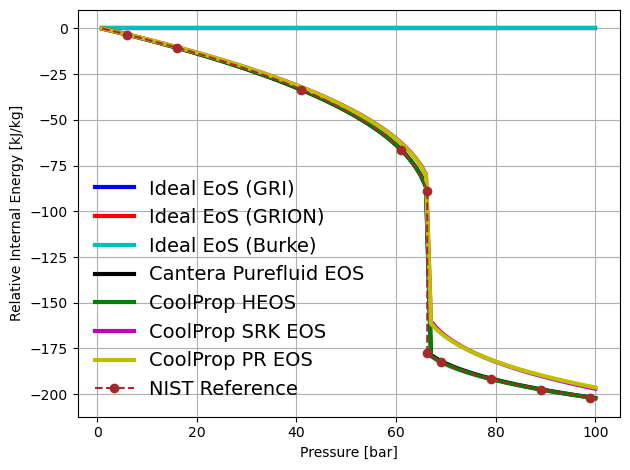

In [280]:
ax = plot(p, "Relative Internal Energy [kJ/kg]", u_ideal_CO2_GRI, u_ideal_CO2_GRION, u_ideal_CO2_Burke, 
     u_Pure_CO2, u_CoolProp_HEOS_CO2, u_CoolProp_SRK_CO2, u_CoolProp_PR_CO2, 
     labels=["Ideal EoS (GRI)", "Ideal EoS (GRION)", "Ideal EoS (Burke)", "Cantera Purefluid EOS", 
             "CoolProp HEOS", "CoolProp SRK EOS", "CoolProp PR EOS"],
    colors=["b", "r", "c", "k", "g", "m", "y"])
ax.plot(CO2_ref['Pressure (atm)'], CO2_ref['Adjusted Internal Energy'], "--", label="NIST Reference", color="brown", marker="o", 
        markevery=[5, 15, 40, 60, 66, 67, 70, 80, 90, 100])
ax.legend(prop={"size": 14}, frameon=False)
plt.show()

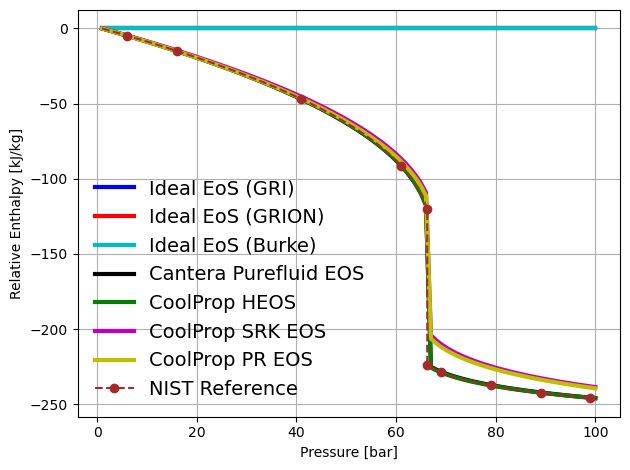

In [281]:
ax = plot(p, "Relative Enthalpy [kJ/kg]", h_ideal_CO2_GRI, h_ideal_CO2_GRION, h_ideal_CO2_Burke, 
     h_Pure_CO2, h_CoolProp_HEOS_CO2, h_CoolProp_SRK_CO2, h_CoolProp_PR_CO2, 
     labels=["Ideal EoS (GRI)", "Ideal EoS (GRION)", "Ideal EoS (Burke)", "Cantera Purefluid EOS", 
             "CoolProp HEOS", "CoolProp SRK EOS", "CoolProp PR EOS"],
    colors=["b", "r", "c", "k", "g", "m", "y"])
ax.plot(CO2_ref['Pressure (atm)'], CO2_ref['Adjusted Enthalpy'], "--", label="NIST Reference", color="brown", marker="o", 
        markevery=[5, 15, 40, 60, 66, 67, 70, 80, 90, 100])
ax.legend(prop={"size": 14}, frameon=False)
plt.show()

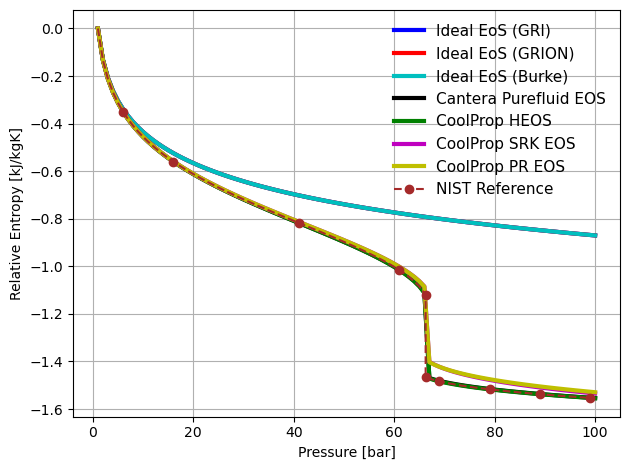

In [282]:
ax = plot(p, "Relative Entropy [kJ/kgK]", s_ideal_CO2_GRI, s_ideal_CO2_GRION, s_ideal_CO2_Burke, 
     s_Pure_CO2, s_CoolProp_HEOS_CO2, s_CoolProp_SRK_CO2, s_CoolProp_PR_CO2, 
     labels=["Ideal EoS (GRI)", "Ideal EoS (GRION)", "Ideal EoS (Burke)", "Cantera Purefluid EOS", 
             "CoolProp HEOS", "CoolProp SRK EOS", "CoolProp PR EOS"],
    colors=["b", "r", "c", "k", "g", "m", "y"])
ax.plot(CO2_ref['Pressure (atm)'], CO2_ref['Adjusted Entropy'], "--", label="NIST Reference", color="brown", marker="o", 
        markevery=[5, 15, 40, 60, 66, 67, 70, 80, 90, 100])
ax.legend(prop={"size": 11}, frameon=False)
plt.show()

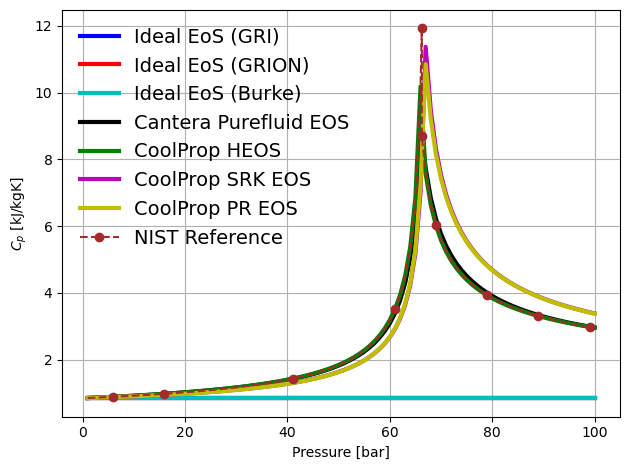

In [283]:
ax = plot(p, "$C_p$ [kJ/kgK]", cp_ideal_CO2_GRI, cp_ideal_CO2_GRION, cp_ideal_CO2_Burke, 
     cp_Pure_CO2, cp_CoolProp_HEOS_CO2, cp_CoolProp_SRK_CO2, cp_CoolProp_PR_CO2, 
     labels=["Ideal EoS (GRI)", "Ideal EoS (GRION)", "Ideal EoS (Burke)", "Cantera Purefluid EOS", 
             "CoolProp HEOS", "CoolProp SRK EOS", "CoolProp PR EOS"],
    colors=["b", "r", "c", "k", "g", "m", "y"])
ax.plot(CO2_ref['Pressure (atm)'], CO2_ref['Cp (J/g*K)'], "--", label="NIST Reference", color="brown", marker="o", 
        markevery=[5, 15, 40, 60, 66, 67, 70, 80, 90, 100])
ax.legend(prop={"size": 14}, frameon=False)
plt.show()

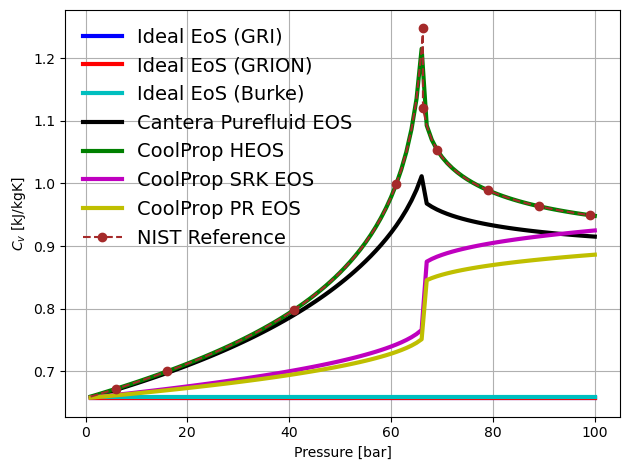

In [284]:
ax = plot(p, "$C_v$ [kJ/kgK]", cv_ideal_CO2_GRI, cv_ideal_CO2_GRION, cv_ideal_CO2_Burke, 
     cv_Pure_CO2, cv_CoolProp_HEOS_CO2, cv_CoolProp_SRK_CO2, cv_CoolProp_PR_CO2, 
     labels=["Ideal EoS (GRI)", "Ideal EoS (GRION)", "Ideal EoS (Burke)", "Cantera Purefluid EOS", 
             "CoolProp HEOS", "CoolProp SRK EOS", "CoolProp PR EOS"],
    colors=["b", "r", "c", "k", "g", "m", "y"])
ax.plot(CO2_ref['Pressure (atm)'], CO2_ref['Cv (J/g*K)'], "--", label="NIST Reference", color="brown", marker="o", 
        markevery=[5, 15, 40, 60, 66, 67, 70, 80, 90, 100])
ax.legend(prop={"size": 14}, frameon=False)
plt.show()

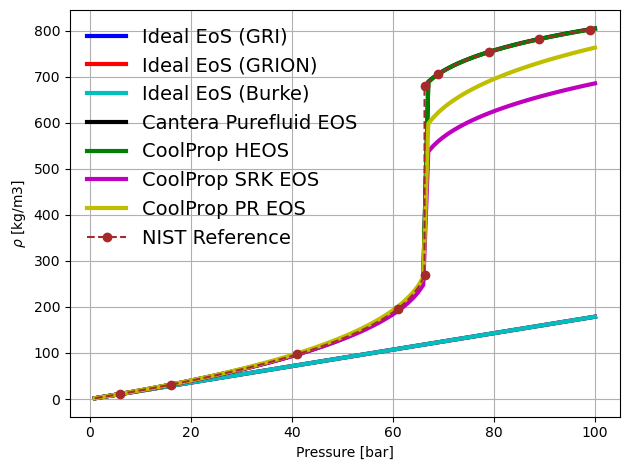

In [292]:
ax = plot(p, r"$\rho$ [kg/m3]", rho_ideal_CO2_GRI, rho_ideal_CO2_GRION, rho_ideal_CO2_Burke, 
     rho_Pure_CO2, rho_CoolProp_HEOS_CO2, rho_CoolProp_SRK_CO2, rho_CoolProp_PR_CO2, 
     labels=["Ideal EoS (GRI)", "Ideal EoS (GRION)", "Ideal EoS (Burke)", "Cantera Purefluid EOS", 
             "CoolProp HEOS", "CoolProp SRK EOS", "CoolProp PR EOS"],
    colors=["b", "r", "c", "k", "g", "m", "y"])
ax.plot(CO2_ref['Pressure (atm)'], CO2_ref['Density (kg/m3)'], "--", label="NIST Reference", color="brown", marker="o", 
        markevery=[5, 15, 40, 60, 66, 67, 70, 80, 90, 100])
ax.legend(prop={"size": 14}, frameon=False)
plt.show()

In [315]:
H2_ref = pd.read_csv('Fluid Reference Data/H2 NIST Reference 300K 1to100atm.csv')
H2_ref.head()

,Temperature (K),Pressure (atm),Density (kg/m3),Volume (m3/kg),Internal Energy (kJ/kg),Adjusted Internal Energy,Enthalpy (kJ/kg),Adjusted Enthalpy,Entropy (J/g*K),Adjusted Entropy,Cv (J/g*K),Cp (J/g*K),Sound Spd. (m/s),Joule-Thomson (F/atm),Viscosity (uPa*s),Therm. Cond. (W/m*K),Phase
0,300,1,0.081841,12.2190,2720.2,0.0,3958.3,0.0,53.464,0.000,10.186,14.313,1319.3,-0.055235,8.9385,0.18670,vapor
1,300,2,0.163580,6.1131,2719.9,-0.3,3958.7,0.4,50.605,-2.859,10.187,14.316,1320.2,-0.055315,8.9390,0.18684,vapor
2,300,3,0.245230,4.0778,2719.6,-0.6,3959.2,0.9,48.931,-4.533,10.188,14.318,1321.0,-0.055396,8.9396,0.18697,vapor
3,300,4,0.326780,3.0601,2719.3,-0.9,3959.6,1.3,47.744,-5.720,10.189,14.321,1321.9,-0.055478,8.9402,0.18710,vapor
4,300,5,0.408240,2.4496,2719.0,-1.2,3960.0,1.7,46.822,-6.642,10.190,14.324,1322.8,-0.055560,8.9408,0.18724,vapor


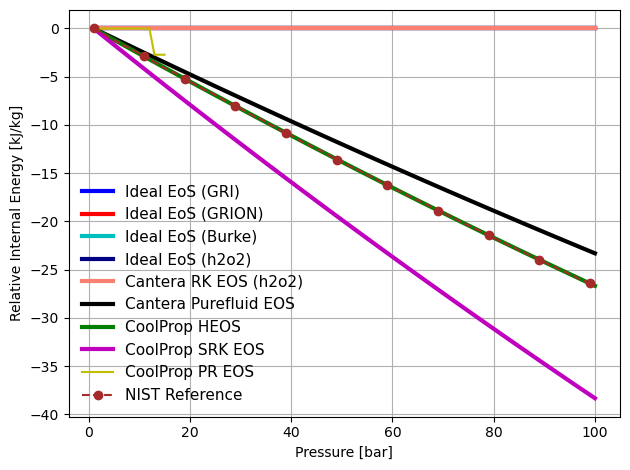

In [329]:
ax = plot(p, "Relative Internal Energy [kJ/kg]", u_ideal_H2_GRI, u_ideal_H2_GRION, u_ideal_H2_Burke,  u_ideal_H2_h2o2,
     u_RK_H2, u_Pure_H2, u_CoolProp_HEOS_H2, u_CoolProp_SRK_H2,
     labels=["Ideal EoS (GRI)", "Ideal EoS (GRION)", "Ideal EoS (Burke)", "Ideal EoS (h2o2)", 
             "Cantera RK EOS (h2o2)", "Cantera Purefluid EOS", "CoolProp HEOS", "CoolProp SRK EOS"],
    colors=["b", "r", "c", "navy", "salmon", "k", "g", "m"])

subset_p = p[0:15]
u_H2_adj = (u_H2 - u_H2[0]) / 1000
subset_u_H2 = u_H2_adj [0:15]
ax.plot(subset_p / 101325, subset_u_H2, "-", label="CoolProp PR EOS", color="y")
ax.plot(H2_ref['Pressure (atm)'], H2_ref['Adjusted Internal Energy'], "--", label="NIST Reference", color="brown", marker="o", 
        markevery=10)
ax.legend(prop={"size": 11}, frameon=False)
plt.show()

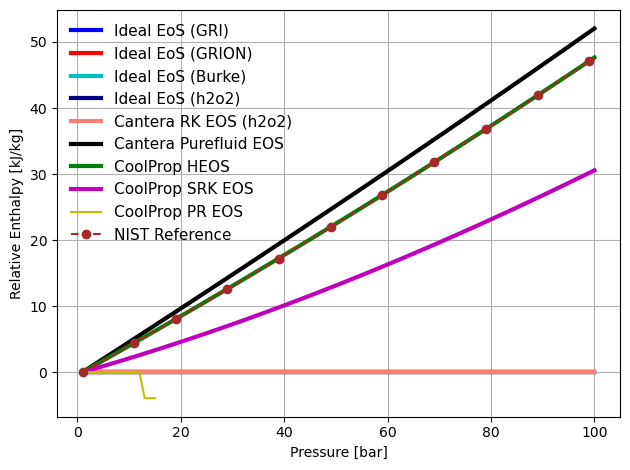

In [330]:
ax = plot(p, "Relative Enthalpy [kJ/kg]", h_ideal_H2_GRI, h_ideal_H2_GRION, h_ideal_H2_Burke,  h_ideal_H2_h2o2,
     h_RK_H2, h_Pure_H2, h_CoolProp_HEOS_H2, h_CoolProp_SRK_H2,
     labels=["Ideal EoS (GRI)", "Ideal EoS (GRION)", "Ideal EoS (Burke)", "Ideal EoS (h2o2)", 
             "Cantera RK EOS (h2o2)", "Cantera Purefluid EOS", "CoolProp HEOS", "CoolProp SRK EOS"],
    colors=["b", "r", "c", "navy", "salmon", "k", "g", "m"])

subset_p = p[0:15]
h_H2_adj = (h_H2 - h_H2[0]) / 1000
subset_h_H2 = h_H2_adj [0:15]
ax.plot(subset_p / 101325, subset_h_H2, "-", label="CoolProp PR EOS", color="y")
ax.plot(H2_ref['Pressure (atm)'], H2_ref['Adjusted Enthalpy'], "--", label="NIST Reference", color="brown", marker="o", 
        markevery=10)
ax.legend(prop={"size": 11}, frameon=False)
plt.show()

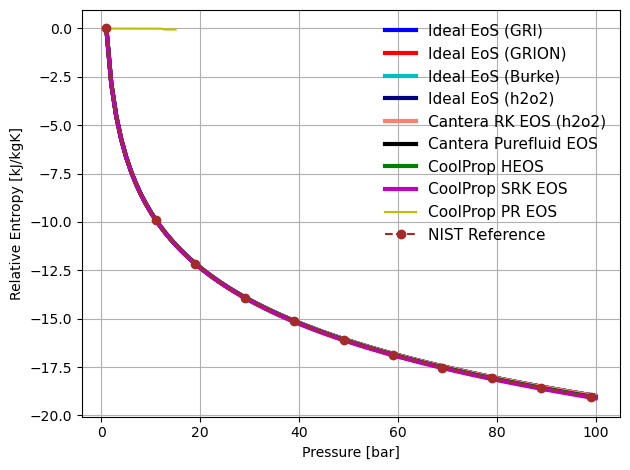

In [331]:
ax = plot(p, "Relative Entropy [kJ/kgK]", s_ideal_H2_GRI, s_ideal_H2_GRION, s_ideal_H2_Burke,  s_ideal_H2_h2o2,
     s_RK_H2, s_Pure_H2, s_CoolProp_HEOS_H2, s_CoolProp_SRK_H2,
     labels=["Ideal EoS (GRI)", "Ideal EoS (GRION)", "Ideal EoS (Burke)", "Ideal EoS (h2o2)", 
             "Cantera RK EOS (h2o2)", "Cantera Purefluid EOS", "CoolProp HEOS", "CoolProp SRK EOS"],
    colors=["b", "r", "c", "navy", "salmon", "k", "g", "m"])

subset_p = p[0:15]
s_H2_adj = (s_H2 - s_H2[0]) / 1000
subset_s_H2 = s_H2_adj [0:15]
ax.plot(subset_p / 101325, subset_s_H2, "-", label="CoolProp PR EOS", color="y")
ax.plot(H2_ref['Pressure (atm)'], H2_ref['Adjusted Entropy'], "--", label="NIST Reference", color="brown", marker="o", 
        markevery=10)
ax.legend(prop={"size": 11}, frameon=False)
plt.show()

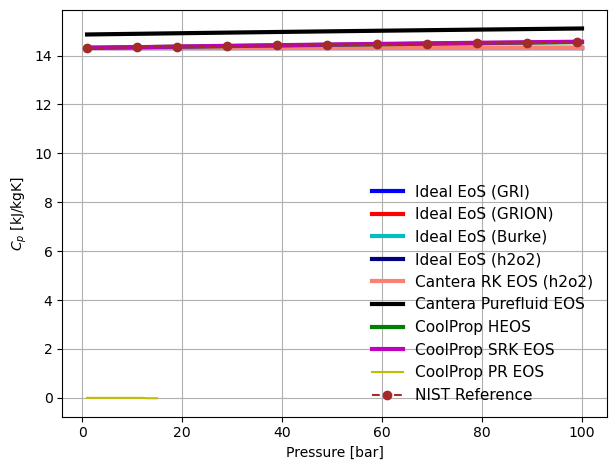

In [332]:
ax = plot(p, "$C_p$ [kJ/kgK]", cp_ideal_H2_GRI, cp_ideal_H2_GRION, cp_ideal_H2_Burke,  cp_ideal_H2_h2o2,
     cp_RK_H2, cp_Pure_H2, cp_CoolProp_HEOS_H2, cp_CoolProp_SRK_H2,
     labels=["Ideal EoS (GRI)", "Ideal EoS (GRION)", "Ideal EoS (Burke)", "Ideal EoS (h2o2)", 
             "Cantera RK EOS (h2o2)", "Cantera Purefluid EOS", "CoolProp HEOS", "CoolProp SRK EOS"],
    colors=["b", "r", "c", "navy", "salmon", "k", "g", "m"])

subset_p = p[0:15]
cp_H2_adj = (cp_H2 - cp_H2[0]) / 1000
subset_cp_H2 = cp_H2_adj [0:15]
ax.plot(subset_p / 101325, subset_cp_H2, "-", label="CoolProp PR EOS", color="y")
ax.plot(H2_ref['Pressure (atm)'], H2_ref['Cp (J/g*K)'], "--", label="NIST Reference", color="brown", marker="o", 
        markevery=10)
ax.legend(prop={"size": 11}, frameon=False)
plt.show()

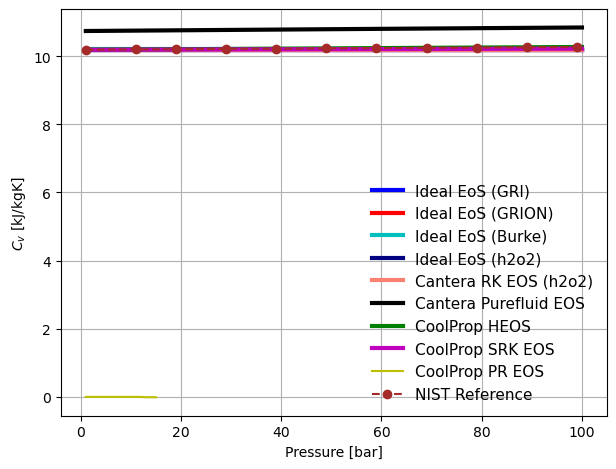

In [333]:
ax = plot(p, "$C_v$ [kJ/kgK]", cv_ideal_H2_GRI, cv_ideal_H2_GRION, cv_ideal_H2_Burke,  cv_ideal_H2_h2o2,
     cv_RK_H2, cv_Pure_H2, cv_CoolProp_HEOS_H2, cv_CoolProp_SRK_H2,
     labels=["Ideal EoS (GRI)", "Ideal EoS (GRION)", "Ideal EoS (Burke)", "Ideal EoS (h2o2)", 
             "Cantera RK EOS (h2o2)", "Cantera Purefluid EOS", "CoolProp HEOS", "CoolProp SRK EOS"],
    colors=["b", "r", "c", "navy", "salmon", "k", "g", "m"])

subset_p = p[0:15]
cv_H2_adj = (cv_H2 - cv_H2[0]) / 1000
subset_cv_H2 = cv_H2_adj [0:15]
ax.plot(subset_p / 101325, subset_cv_H2, "-", label="CoolProp PR EOS", color="y")
ax.plot(H2_ref['Pressure (atm)'], H2_ref['Cv (J/g*K)'], "--", label="NIST Reference", color="brown", marker="o", 
        markevery=10)
ax.legend(prop={"size": 11}, frameon=False)
plt.show()

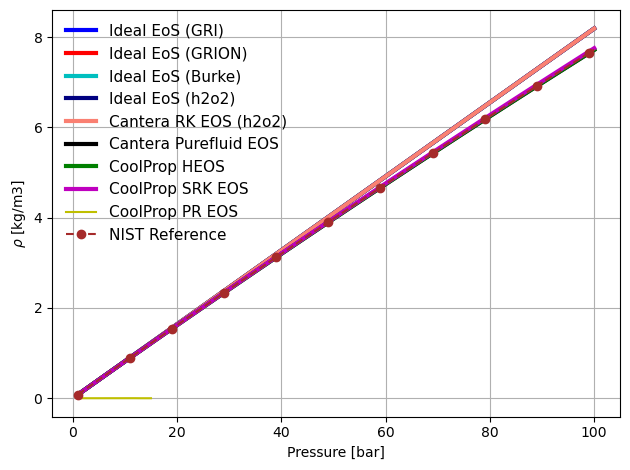

In [334]:
ax = plot(p, r"$\rho$ [kg/m3]", rho_ideal_H2_GRI, rho_ideal_H2_GRION, rho_ideal_H2_Burke,  rho_ideal_H2_h2o2,
     rho_RK_H2, rho_Pure_H2, rho_CoolProp_HEOS_H2, rho_CoolProp_SRK_H2,
     labels=["Ideal EoS (GRI)", "Ideal EoS (GRION)", "Ideal EoS (Burke)", "Ideal EoS (h2o2)", 
             "Cantera RK EOS (h2o2)", "Cantera Purefluid EOS", "CoolProp HEOS", "CoolProp SRK EOS"],
    colors=["b", "r", "c", "navy", "salmon", "k", "g", "m"])

subset_p = p[0:15]
rho_H2_adj = (rho_H2 - rho_H2[0]) / 1000
subset_rho_H2 = rho_H2_adj [0:15]
ax.plot(subset_p / 101325, subset_rho_H2, "-", label="CoolProp PR EOS", color="y")
ax.plot(H2_ref['Pressure (atm)'], H2_ref['Density (kg/m3)'], "--", label="NIST Reference", color="brown", marker="o", 
        markevery=10)
ax.legend(prop={"size": 11}, frameon=False)
plt.show()

## Temperature-Density plots

The following function plots the $T$-$\rho$ diagram over a wide pressure
and temperature range. The temperature is varied from 250 K to 400 K. The pressure is
changed from 1 bar to 600 bar.



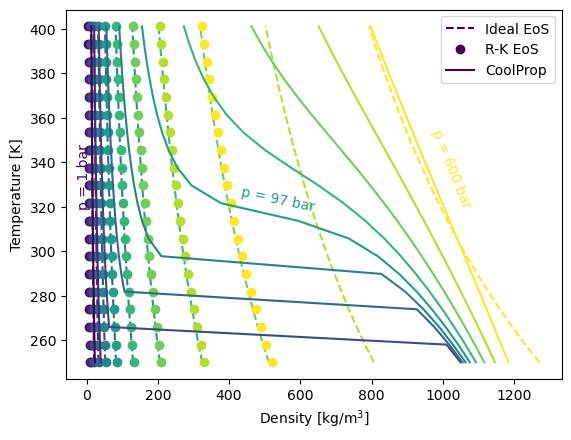

In [335]:
# Input parameters
# Set up arrays for pressure and temperature
p_array = np.logspace(1, np.log10(600), 10, endpoint=True)
T_array = np.linspace(250, 401, 20)  # Temperature is varied from 250K to 400K
p_array = 1e5 * np.array(p_array)[:, np.newaxis]

# Calculate densities for Ideal gas and R-K EoS phases
states = ct.SolutionArray(ideal_gas_phase, shape=(p_array.size, T_array.size))
states.TP = T_array, p_array
density_ideal = states.density_mass

states = ct.SolutionArray(redlich_kwong_phase, shape=(p_array.size, T_array.size))
states.TP = T_array, p_array
density_RK = states.density_mass

p, T = np.meshgrid(p_array, T_array)
density_coolprop = PropsSI("D", "P", np.ravel(p), "T", np.ravel(T), "CO2")
density_coolprop = density_coolprop.reshape(p.shape)

# Plot
import cycler
color = plt.cm.viridis(np.linspace(0, 1, p_array.size))
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

fig, ax = plt.subplots()
ideal_line = ax.plot(density_ideal.T, T_array, "--", label="Ideal EoS")
RK_line = ax.plot(density_RK.T, T_array, "o", label="R-K EoS")
CP_line = ax.plot(density_coolprop, T_array, "-", label="CoolProp")
ax.text(-27.5, 320, "p = 1 bar", color=color[0], rotation="vertical")
ax.text(430, 318, "p = 97 bar", color=color[5], rotation=-12)
ax.text(960, 320, "p = 600 bar", color=color[9], rotation=-68)
ax.set_xlabel("Density [kg/m$^3$]")
ax.set_ylabel("Temperature [K]")
ax.legend(handles=[ideal_line[0], RK_line[0], CP_line[0]])

The figure compares $T-\rho$ plots for ideal, R-K, and Helmholtz EoS at
different operating pressures. All three EoS yield the same plots at low pressures (0
bar and 10 bar). However, the Ideal gas EoS departs significantly at high pressures
($P > 10$ bar), where non-ideal effects are prominent. The R-K EoS closely
matches the Helmholtz EoS at supercritical pressures ($P \ge 70$ bar). However,
it does depart in the liquid-vapor region that exists at $P < P_{\rm {crit}}$
and low temperatures ($~T_{\rm {crit}}$).

.. [1] I.H. Bell, J. Wronski, S. Quoilin, V. Lemort, "Pure and Pseudo-pure Fluid
   Thermophysical Property Evaluation and the Open-Source Thermophysical Property
   Library CoolProp," Industrial & Engineering Chemistry Research 53 (2014),
   https://pubs.acs.org/doi/10.1021/ie4033999

.. [2] R. Span, "Multiparameter Equations of State - An Accurate Source of
   Thermodynamic Property Data," Springer Berlin Heidelberg (2000),
   https://dx.doi.org/10.1007/978-3-662-04092-8

.. [3] A. Saeed, S. Ghader, "Calculation of density, vapor pressure and heat capacity
   near the critical point by incorporating cubic SRK EoS and crossover translation,"
   Fluid Phase Equilibria (2019) 493, https://doi.org/10.1016/j.fluid.2019.03.027

